In [1]:
import pandas as pd
import numpy as np                              
import configparser
import os
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

In [8]:
## Using an ini file for credentials, otherwise providing defaults
uri = "bolt://localhost:7687"   # Hoặc thay đổi nếu cổng khác
username = "neo4j"              # Tên đăng nhập của Neo4j
password = "12345678"      # Mật khẩu của Neo4j

In [10]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(uri, auth=(username, password))

In [11]:
# Machine Learning Training & Evaluation
# Get and Prepare Data
df = gds.run_cypher('''
    MATCH(u:User)
    RETURN u.guid AS guid,
        u.wccId AS wccId,
        u.fraudRisk AS fraudRisk,
        u.fraudMoneyTransfer AS fraudMoneyTransfer,
        u.sharedIdsDegree AS sharedIdsDegree,
        u.p2pSharedCardPageRank AS p2pSharedCardPageRank,
        u.p2pSentPageRank AS p2pSentPageRank,
        u.p2pReceivedWeightedPageRank AS p2pReceivedWeightedPageRank,
        u.p2pReceivedWeightedDegree AS p2pReceivedWeightedDegree,
        u.ipDegree AS ipDegree,
        u.cardDegree AS cardDegree,
        u.deviceDegree AS deviceDegree,
        u.communitySize AS communitySize,
        u.partOfCommunity AS partOfCommunity
''')
df

,guid,wccId,fraudRisk,fraudMoneyTransfer,sharedIdsDegree,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,be0222d26897046dc92ae2929d3427e7,0,0,0,0.0,0.150000,0.175463,0.414298,10.0,21.0,3.0,4.0,1,0
1,59515432f0e2e79b83e9524c94f7f86e,1,0,0,0.0,0.150000,0.310576,0.150422,10.0,7.0,1.0,1.0,1,0
2,ba1f4324c66ee093478d41a6826a3649,2,0,0,0.0,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,8a18e1625e35a9f66abfd7bd2d04f0b3,3,0,0,0.0,0.150000,0.230177,0.319779,100.0,135.0,12.0,2.0,1,0
4,9f705a0107acc25a57f9e6aa8436a08e,4,0,0,0.0,0.150000,0.391428,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33726,f3693169dcc9064114a171c5c2f485b5,33726,0,0,0.0,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33727,10f7f048645c602de3fae7c2cf81b254,27912,0,0,1.0,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33728,d3a4469957800636802a8de4874af1bc,33728,0,0,0.0,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33729,4698ccb2e4b07b1974741f634115e49b,33729,0,0,0.0,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [12]:
# X: Tập dữ liệu đặc trưng đầu vào cho mô hình, loại bỏ các cột không cần thiết:
# Loại bỏ fraudRisk, fraudMoneyTransfer (vì đây là mục tiêu dự đoán).
# Loại bỏ wccId và guid (không mang giá trị cho mô hình học máy).
# X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid', 'p2pSentPageRank', 'p2pReceivedWeightedPageRank','cardDegree','p2pReceivedWeightedDegree', 'p2pSharedCardPageRank', 'deviceDegree'])
X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid'])
# y: Biến mục tiêu (target variable):
# df.fraudRisk - df.fraudMoneyTransfer:
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 0 → tài khoản nguy cơ rủi ro → y = 1.
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 1 → tài khoản đã chuyển tiền gian lận → y = 0.
# Nếu fraudRisk = 0 → tài khoản an toàn → y = 0.
y = df.fraudRisk - df.fraudMoneyTransfer

# Tài khoản đã gian lận được gán y = 0, thực hiện phát hiện sớm các tài khoản có nguy cơ gian lân
# Khiến mô hình học là: đặc điểm của tài khoản gian lận là không gian lận
# Điều này có hợp lí không ????

In [68]:
a = [f"{df['fraudRisk'].iloc[idx]}_{df['fraudMoneyTransfer'].iloc[idx]}" for idx in range(len(df))]

In [69]:
np.unique(a)

array(['0_0', '1_0', '1_1'], dtype='<U3')

In [64]:
np.unique(df['fraudRisk'] - df['fraudMoneyTransfer'])

array([0, 1], dtype=int64)

In [63]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([33520,   211], dtype=int64))

In [13]:
print(X)

       sharedIdsDegree  p2pSharedCardPageRank  p2pSentPageRank  \
0                  0.0               0.150000         0.175463   
1                  0.0               0.150000         0.310576   
2                  0.0               0.150000         0.277500   
3                  0.0               0.150000         0.230177   
4                  0.0               0.150000         0.391428   
...                ...                    ...              ...   
33726              0.0               0.150000         0.297005   
33727              1.0               0.999999         0.371382   
33728              0.0               0.150000         0.150000   
33729              0.0               0.150000         0.181054   
33730              0.0               0.150000         0.185296   

       p2pReceivedWeightedPageRank  p2pReceivedWeightedDegree  ipDegree  \
0                         0.414298                       10.0      21.0   
1                         0.150422                       

In [14]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
33726    0
33727    0
33728    0
33729    0
33730    0
Length: 33731, dtype: int64


In [2]:
import os
import pickle
from sklearn.model_selection import train_test_split

# Tên file lưu
split_file = "splitted_data.pkl"

if os.path.exists(split_file):
    print("Tải data đã lưu")
    with open(split_file, "rb") as f:
        data_splits = pickle.load(f)
    # Lấy các tập dữ liệu từ dictionary
    X_train = data_splits["X_train"]
    X_val = data_splits["X_val"]
    X_test = data_splits["X_test"]
    y_train = data_splits["y_train"]
    y_val = data_splits["y_val"]
    y_test = data_splits["y_test"]
    X_train_val = data_splits["X_train_val"]
    y_train_val = data_splits["y_train_val"]
else:
    print("Lưu data vào file")
    # Giả sử X và y đã được định nghĩa sẵn
    # Chia dữ liệu thành tập train+val (80%) và test (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Chia tiếp tập train_val thành train (75% của train_val) và val (25% của train_val)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )

    # Lưu lại toàn bộ các tập dưới dạng dictionary, bao gồm cả train_val
    data_splits = {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "X_train_val": X_train_val,
        "y_train_val": y_train_val
    }
    
    with open(split_file, "wb") as f:
        pickle.dump(data_splits, f)
    print("Đã lưu vào file: ", split_file)


Tải data đã lưu


In [3]:
print("Hình dạng của X_train:", np.array(X_train).shape)
print("Hình dạng của y_train:", np.array(y_train).shape)


Hình dạng của X_train: (20238, 10)
Hình dạng của y_train: (20238,)



Phân phối dữ liệu Ban Đầu:
Lớp 0: 33520 mẫu (99.37%)
Lớp 1: 211 mẫu (0.63%)


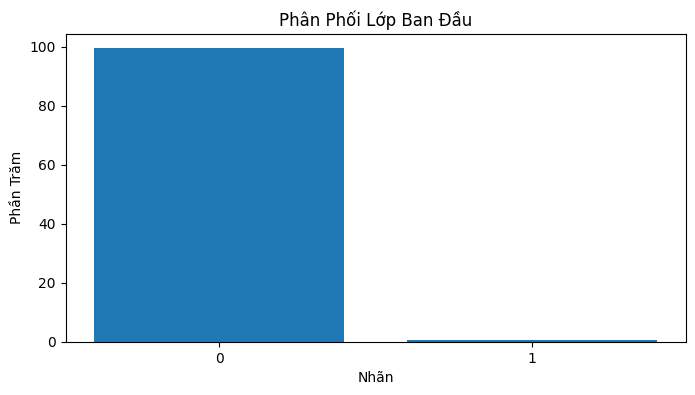


Phân phối dữ liệu Train+Validation:
Lớp 0: 26815 mẫu (99.37%)
Lớp 1: 169 mẫu (0.63%)


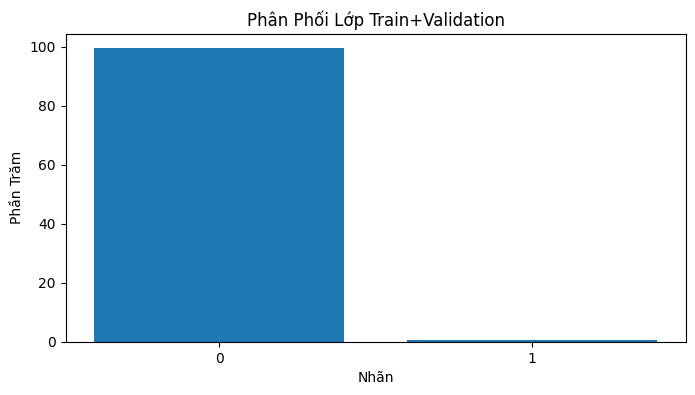


Phân phối dữ liệu Train:
Lớp 0: 20111 mẫu (99.37%)
Lớp 1: 127 mẫu (0.63%)


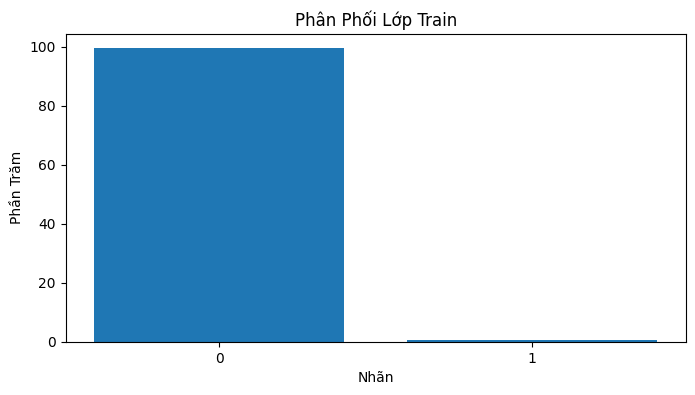


Phân phối dữ liệu Validation:
Lớp 0: 6704 mẫu (99.38%)
Lớp 1: 42 mẫu (0.62%)


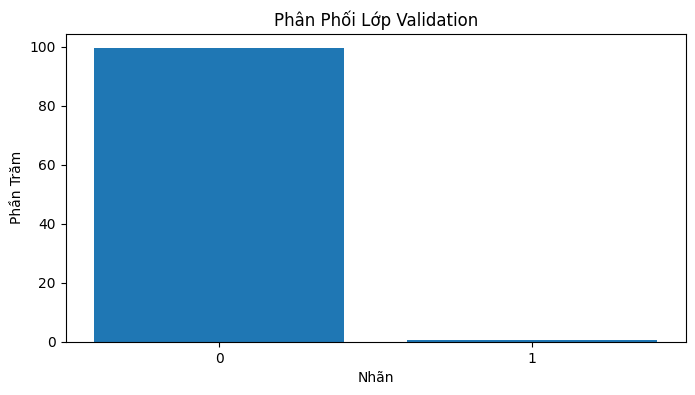


Phân phối dữ liệu Test:
Lớp 0: 6705 mẫu (99.38%)
Lớp 1: 42 mẫu (0.62%)


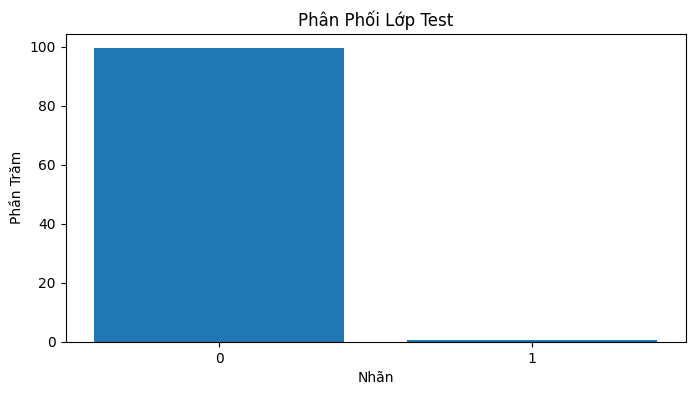


Kích thước các tập:
Train: (20238, 10)
Validation: (6746, 10)
Test: (6747, 10)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def check_data_distribution(y, label=''):
    """Kiểm tra phân phối dữ liệu"""
    unique, counts = np.unique(y, return_counts=True)
    percentages = counts / len(y) * 100
    
    print(f"\nPhân phối dữ liệu {label}:")
    for value, count, percentage in zip(unique, counts, percentages):
        print(f"Lớp {value}: {count} mẫu ({percentage:.2f}%)")
    
    plt.figure(figsize=(8, 4))
    plt.bar(unique.astype(str), percentages)
    plt.title(f'Phân Phối Lớp {label}')
    plt.xlabel('Nhãn')
    plt.ylabel('Phần Trăm')
    plt.show()

def stratified_split_with_check(X, y, test_size=0.2, val_size=0.25, random_state=42):
    """
    Chia dữ liệu với kiểm tra phân phối chặt chẽ
    
    Parameters:
    - X: Ma trận đặc trưng
    - y: Nhãn
    - test_size: Tỷ lệ tập test
    - val_size: Tỷ lệ tập validation
    - random_state: Seed ngẫu nhiên
    
    Returns:
    - X_train, X_val, X_test
    - y_train, y_val, y_test
    """
    # Kiểm tra phân phối ban đầu
    check_data_distribution(y, 'Ban Đầu')
    
    # Chia tập test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y  # Đảm bảo phân phối đều
    )
    
    # Kiểm tra phân phối train_val
    check_data_distribution(y_train_val, 'Train+Validation')
    
    # Chia tiếp train và validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=val_size,  # Lưu ý: val_size là so với train_val
        random_state=random_state, 
        stratify=y_train_val  # Đảm bảo phân phối đều
    )
    
    # Kiểm tra phân phối của từng tập
    check_data_distribution(y_train, 'Train')
    check_data_distribution(y_val, 'Validation')
    check_data_distribution(y_test, 'Test')
    
    # In kích thước các tập (số hàng, số cột) 
    print("\nKích thước các tập:")
    print(f"Train: {X_train.shape}")
    print(f"Validation: {X_val.shape}")
    print(f"Test: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Sử dụng
X_train, X_val, X_test, y_train, y_val, y_test = stratified_split_with_check(X, y)

In [2]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
# Định nghĩa cross-validation phù hợp đảm bảo tỷ lệ fraud/non-fraud được giữ nguyên trong mỗi fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Thêm class_weight giúp tăng khả năng phát hiện class 1 (recall) nhưng khiến precision và accuracy giảm vì đánh nhầm nhiều class 0.
#-> Bắt lầm còn hơn bỏ sót 
# Không thêm class_weight giúp tổng thể chính xác hơn, nhưng lại bỏ sót khá nhiều trường hợp class 1.
#-> Đám bảo kết quả chính xác, có thể bỏ sót 1 vài giá trị 

# Tạo Pipeline gồm 2 bước: SMOTE và Decision Tree
pipeline_dt = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(class_weight={0: 1, 1: 200}, random_state=42))
])

# Grid các siêu tham số, lưu ý thay đổi tên tham số của Decision Tree thành 'dt__'
dt_param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 5, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__max_features': ['sqrt', 'log2', None]
}

# Sử dụng GridSearchCV với scoring = 'roc_auc'
dt_grid = GridSearchCV(estimator=pipeline_dt,
                       param_grid=dt_param_grid,
                       cv=cv,
                       scoring='roc_auc',
                       n_jobs=-1,
                       verbose=1)

# Huấn luyện mô hình trên tập huấn luyện
dt_grid.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_model_dt = dt_grid.best_estimator_
print("Best Parameters:", dt_grid.best_params_)

# Dự đoán trên các tập dữ liệu
y_test_pred = best_model_dt.predict(X_test)

print("\nKết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters: {'dt__criterion': 'gini', 'dt__max_depth': 5, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}

Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      6705
           1       0.02      0.98      0.04        42

    accuracy                           0.73      6747
   macro avg       0.51      0.85      0.44      6747
weighted avg       0.99      0.73      0.84      6747



In [20]:
from sklearn.ensemble import RandomForestClassifier

# Tạo Pipeline gồm SMOTE và RandomForestClassifier
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight={0: 1, 1: 200}, random_state=42))
])

# Định nghĩa grid siêu tham số với tiền tố 'rf__' để tham chiếu đến bước RandomForest trong pipeline
rf_param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

# Thiết lập GridSearchCV với scoring là 'roc_auc' phù hợp với bài toán dữ liệu mất cân bằng
rf_grid = GridSearchCV(pipeline_rf, rf_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

# Huấn luyện mô hình trên tập huấn luyện
rf_grid.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_model_rf = rf_grid.best_estimator_
print("Random Forest - Best Parameters:", rf_grid.best_params_)

# Dự đoán trên các tập dữ liệu
y_test_pred = best_model_rf.predict(X_test)

# In kết quả đánh giá
print("\nRandom Forest - Test set:")
print(classification_report(y_test, y_test_pred, zero_division=0))



Fitting 5 folds for each of 96 candidates, totalling 480 fits
Random Forest - Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}

Random Forest - Test set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6705
           1       0.11      0.14      0.12        42

    accuracy                           0.99      6747
   macro avg       0.55      0.57      0.56      6747
weighted avg       0.99      0.99      0.99      6747



In [12]:
# Sử dụng randomized vì grid quá mất thời gian
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import SVC

# Xây dựng pipeline gồm SMOTE và SVC
pipeline_svm = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(class_weight='balanced'))
])

# Định nghĩa không gian tìm kiếm siêu tham số với tiền tố 'svc__'
svm_random_grid = {
    'svc__C': uniform(0.1, 10),
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf']
}

# Thiết lập RandomizedSearchCV với cv đã được định nghĩa từ trước
svm_search = RandomizedSearchCV(
    estimator=pipeline_svm,
    param_distributions=svm_random_grid,
    n_iter=10,
    cv=cv,
    scoring='roc_auc',  # sử dụng roc_auc làm chỉ số tối ưu
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Huấn luyện mô hình trên tập huấn luyện
svm_search.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_model_svm = svm_search.best_estimator_

# Dự đoán trên các tập dữ liệu
y_test_pred = best_model_svm.predict(X_test)

# Đánh giá mô hình
print("Đánh giá mô hình SVM:")
print("Best Parameters:", svm_search.best_params_)


print("\nKết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Đánh giá mô hình SVM:
Best Parameters: {'svc__C': 0.6641157902710025, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}

Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6705
           1       0.04      0.24      0.07        42

    accuracy                           0.96      6747
   macro avg       0.52      0.60      0.53      6747
weighted avg       0.99      0.96      0.97      6747



In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Tạo pipeline gồm SMOTE và KNeighborsClassifier
pipeline_knn = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# Định nghĩa không gian siêu tham số, lưu ý tiền tố 'knn__' để tham chiếu các tham số của KNeighborsClassifier trong pipeline
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

# Sử dụng GridSearchCV với cv đã định nghĩa và scoring = 'roc_auc'
knn_grid = GridSearchCV(pipeline_knn,
                        knn_param_grid,
                        cv=cv,
                        scoring='roc_auc',
                        n_jobs=-1,
                        verbose=1)

# Huấn luyện mô hình trên tập huấn luyện
knn_grid.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_model_knn = knn_grid.best_estimator_
print("KNN - Best Parameters:", knn_grid.best_params_)

# Dự đoán trên các tập dữ liệu
y_test_pred = best_model_knn.predict(X_test)

# In kết quả đánh giá trên từng tập
print("\nKNN - Test set:")
print(classification_report(y_test, y_test_pred, zero_division=0))



Fitting 5 folds for each of 16 candidates, totalling 80 fits
KNN - Best Parameters: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}

KNN - Test set:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      6705
           1       0.03      0.43      0.06        42

    accuracy                           0.92      6747
   macro avg       0.51      0.67      0.51      6747
weighted avg       0.99      0.92      0.95      6747



In [14]:
from sklearn.neural_network import MLPClassifier

# Tạo Pipeline gồm hai bước: SMOTE và MLPClassifier
pipeline_mlp = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])

# Định nghĩa grid siêu tham số cho MLPClassifier, lưu ý sử dụng tiền tố 'mlp__'
mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001],
    'mlp__learning_rate': ['constant', 'adaptive']
}

# Sử dụng GridSearchCV với scoring = 'roc_auc'
mlp_grid = GridSearchCV(pipeline_mlp, mlp_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

# Huấn luyện mô hình
mlp_grid.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_model_mlp = mlp_grid.best_estimator_
print("MLP - Best Parameters:", mlp_grid.best_params_)

# Dự đoán trên các tập dữ liệu
y_test_pred = best_model_mlp.predict(X_test)

# In kết quả đánh giá trên các tập
print("\nMLP - Test set:")
print(classification_report(y_test, y_test_pred, zero_division=0))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
MLP - Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}

MLP - Test set:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      6705
           1       0.02      0.83      0.05        42

    accuracy                           0.78      6747
   macro avg       0.51      0.81      0.46      6747
weighted avg       0.99      0.78      0.87      6747



In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight

# Tính trọng số và tạo class_prior cho GaussianNB
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_prior = class_weights / class_weights.sum()

# Xây dựng Pipeline gồm SMOTE và GaussianNB
pipeline_nb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('nb', GaussianNB(priors=class_prior))
])

# Định nghĩa grid siêu tham số, lưu ý sử dụng tiền tố 'nb__'
nb_param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7]
}

# Thiết lập GridSearchCV với scoring = 'roc_auc'
nb_grid = GridSearchCV(pipeline_nb,
                       nb_param_grid,
                       cv=cv,
                       scoring='roc_auc',
                       n_jobs=-1,
                       verbose=1)

# Huấn luyện mô hình trên tập huấn luyện
nb_grid.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_model_nb = nb_grid.best_estimator_
print("Naive Bayes - Best Parameters:", nb_grid.best_params_)

# Dự đoán trên các tập dữ liệu
y_test_pred = best_model_nb.predict(X_test)

# In kết quả đánh giá trên từng tập
print("\nNaive Bayes - Test set:")
print(classification_report(y_test, y_test_pred, zero_division=0))



Fitting 5 folds for each of 3 candidates, totalling 15 fits
Naïve Bayes - Best Parameters: {'nb__var_smoothing': 1e-09}

Naïve Bayes - Test set:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      6705
           1       0.02      0.93      0.04        42

    accuracy                           0.75      6747
   macro avg       0.51      0.84      0.45      6747
weighted avg       0.99      0.75      0.85      6747



In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


# Tạo Pipeline gồm SMOTE và BaggingClassifier
pipeline_bag = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('bag', BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
        random_state=42))
])

# Định nghĩa grid siêu tham số cho BaggingClassifier,
# lưu ý tiền tố 'bag__' để tham chiếu đến tham số của BaggingClassifier trong pipeline.
bagging_param_grid = {
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 1.0],
    'bag__max_features': [0.5, 1.0],
    'bag__bootstrap': [True, False]
}

# Thiết lập GridSearchCV với scoring 'roc_auc'
bagging_grid = GridSearchCV(pipeline_bag, 
                            bagging_param_grid, 
                            cv=cv, 
                            scoring='roc_auc', 
                            n_jobs=-1, 
                            verbose=1)

# Huấn luyện mô hình trên tập huấn luyện
bagging_grid.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_model_bag = bagging_grid.best_estimator_
print("Bagging - Best Parameters:", bagging_grid.best_params_)

# Dự đoán trên các tập dữ liệu
y_test_pred = best_model_bag.predict(X_test)

# In kết quả đánh giá trên các tập
print("\nBagging - Test set:")
print(classification_report(y_test, y_test_pred, zero_division=0))



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Bagging - Best Parameters: {'bag__bootstrap': True, 'bag__max_features': 0.5, 'bag__max_samples': 1.0, 'bag__n_estimators': 100}

Bagging - Test set:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.17      0.02      0.04        42

    accuracy                           0.99      6747
   macro avg       0.58      0.51      0.52      6747
weighted avg       0.99      0.99      0.99      6747



In [4]:
# Đường dẫn đến file lưu best models
filename = "best_models.pkl"

# Nếu file đã tồn tại thì load các mô hình và in các siêu tham số ra
if os.path.exists(filename):
    print(f"File '{filename}' đã tồn tại. Tải các mô hình")
    with open(filename, "rb") as file:
        best_models = pickle.load(file)
else:
    # Dictionary chứa các best model
    best_models = {
        "Decision Tree": best_model_dt,
        "Random Forest": best_model_rf,
        "SVM": best_model_svm,
        "Naive Bayes": best_model_nb,
        "KNN": best_model_knn,
        "MLP": best_model_mlp,
        "Bagging": best_model_bag
    }

    # Lưu dictionary các mô hình đã huấn luyện vào file .pkl
    with open(filename, "wb") as file:
        pickle.dump(best_models, file)
    print(f"\nCác best models đã được lưu vào file '{filename}'.")



File 'best_models.pkl' đã tồn tại. Tải các mô hình


In [5]:
# In các siêu tham số của từng mô hình
print("\n--- In các siêu tham số của các mô hình đã lưu ---")
for model_name, model in best_models.items():
    print(f"\nSiêu tham số của mô hình {model_name}:")
    try:
        # Lấy danh sách các siêu tham số thông qua hàm get_params() của scikit-learn
        params = model.get_params()
        for param, value in params.items():
            print(f"  {param}: {value}")
    except Exception as e:
        print(f"  Không thể lấy siêu tham số cho mô hình {model_name}: {e}")


--- In các siêu tham số của các mô hình đã lưu ---

Siêu tham số của mô hình Decision Tree:
  memory: None
  steps: [('smote', SMOTE(random_state=42)), ('dt', DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, random_state=42))]
  transform_input: None
  verbose: False
  smote: SMOTE(random_state=42)
  dt: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, random_state=42)
  smote__k_neighbors: 5
  smote__random_state: 42
  smote__sampling_strategy: auto
  dt__ccp_alpha: 0.0
  dt__class_weight: balanced
  dt__criterion: entropy
  dt__max_depth: 5
  dt__max_features: None
  dt__max_leaf_nodes: None
  dt__min_impurity_decrease: 0.0
  dt__min_samples_leaf: 1
  dt__min_samples_split: 2
  dt__min_weight_fraction_leaf: 0.0
  dt__monotonic_cst: None
  dt__random_state: 42
  dt__splitter: best

Siêu tham số của mô hình Random Forest:
  memory: None
  steps: [('smote', SMOTE(random_state

In [7]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

--- Báo cáo phân loại cho mô hình Decision Tree trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      6705
           1       0.04      0.71      0.08        42

    accuracy                           0.89      6747
   macro avg       0.52      0.80      0.51      6747
weighted avg       0.99      0.89      0.94      6747


Confusion Matrix for Decision Tree:


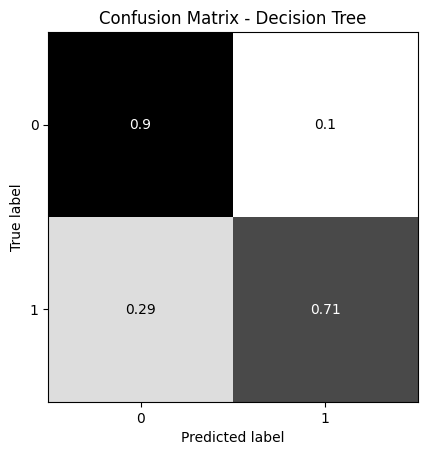

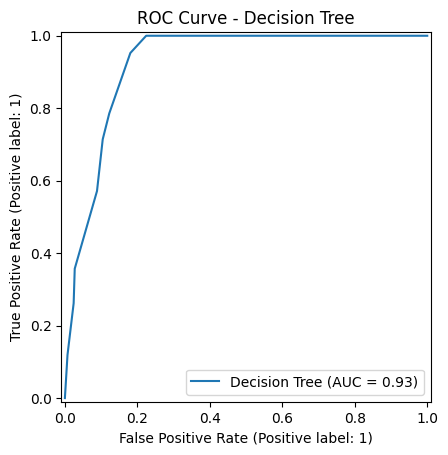

--- Báo cáo phân loại cho mô hình Random Forest trên tập Test ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6705
           1       0.17      0.17      0.17        42

    accuracy                           0.99      6747
   macro avg       0.58      0.58      0.58      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix for Random Forest:


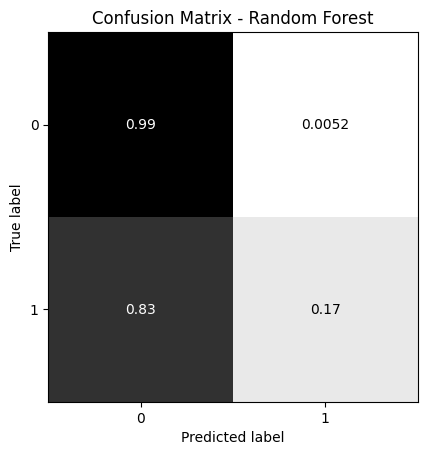

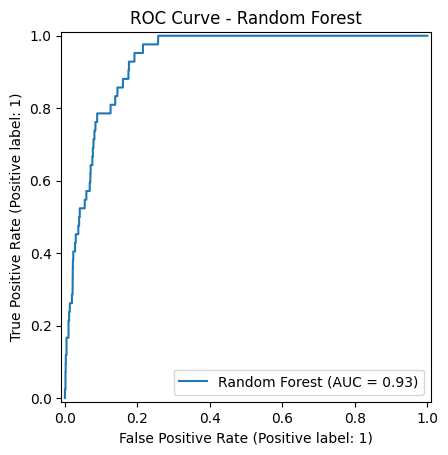

--- Báo cáo phân loại cho mô hình SVM trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6705
           1       0.06      0.26      0.09        42

    accuracy                           0.97      6747
   macro avg       0.53      0.62      0.54      6747
weighted avg       0.99      0.97      0.98      6747


Confusion Matrix for SVM:


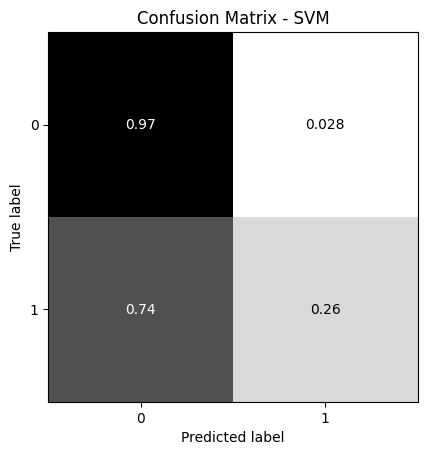

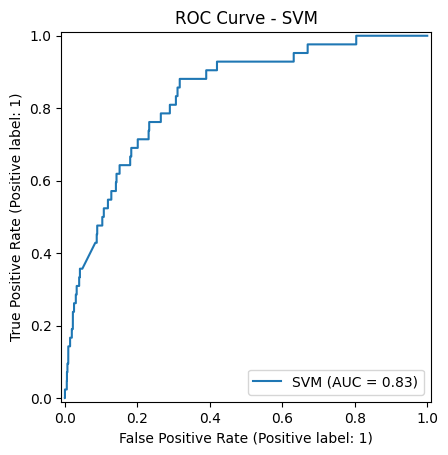

--- Báo cáo phân loại cho mô hình Naive Bayes trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      6705
           1       0.02      0.95      0.04        42

    accuracy                           0.73      6747
   macro avg       0.51      0.84      0.44      6747
weighted avg       0.99      0.73      0.84      6747


Confusion Matrix for Naive Bayes:


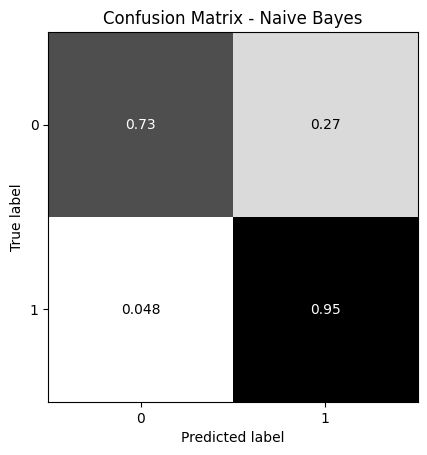

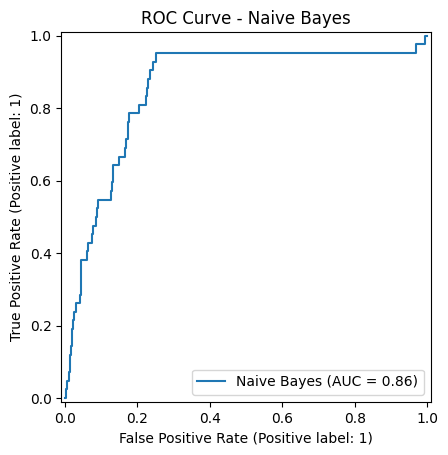

--- Báo cáo phân loại cho mô hình KNN trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      6705
           1       0.04      0.45      0.07        42

    accuracy                           0.93      6747
   macro avg       0.52      0.69      0.52      6747
weighted avg       0.99      0.93      0.96      6747


Confusion Matrix for KNN:


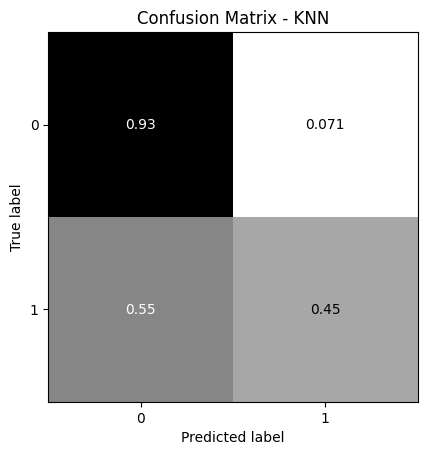

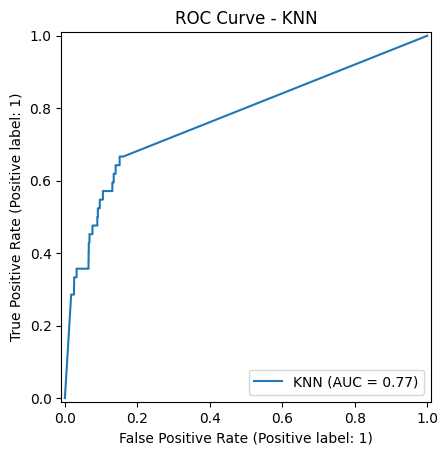

--- Báo cáo phân loại cho mô hình MLP trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      6705
           1       0.02      0.90      0.04        42

    accuracy                           0.74      6747
   macro avg       0.51      0.82      0.44      6747
weighted avg       0.99      0.74      0.84      6747


Confusion Matrix for MLP:


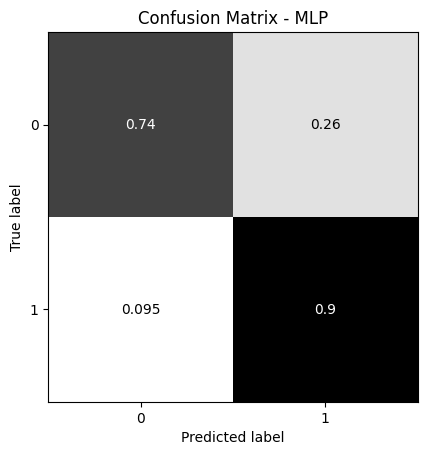

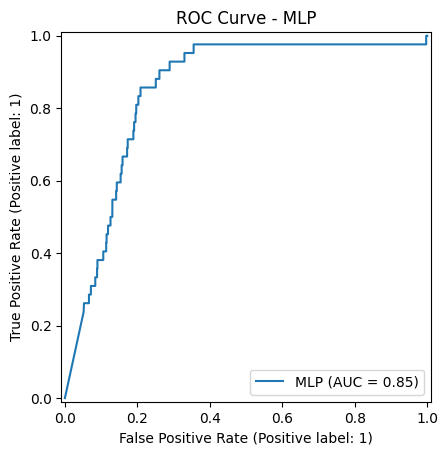

--- Báo cáo phân loại cho mô hình Bagging trên tập Test ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.40      0.05      0.09        42

    accuracy                           0.99      6747
   macro avg       0.70      0.52      0.54      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix for Bagging:


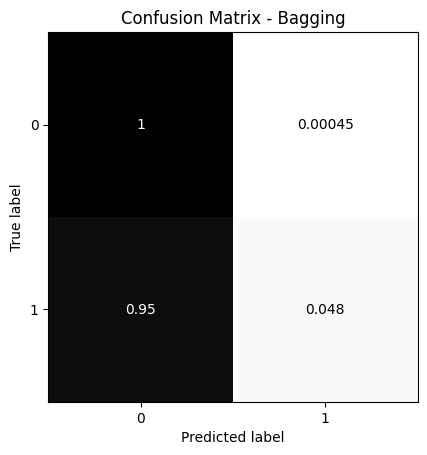

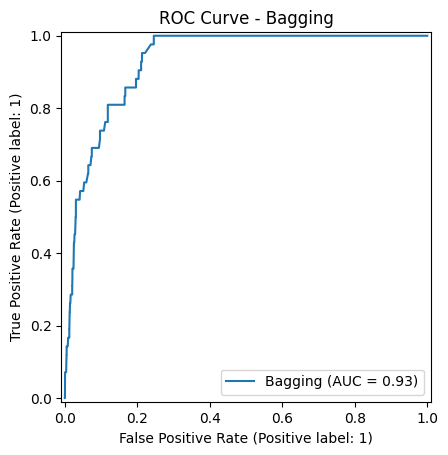

In [12]:
# Re-fit (huấn luyện lại) các mô hình trên tập train_val
for model_name, model in best_models.items():
    # Huấn luyện lại mô hình trên tập train_val
    model.fit(X_train_val, y_train_val)
    
    # Dự đoán trên tập test
    y_test_pred = model.predict(X_test)
    
    # In báo cáo phân loại cho mô hình trên tập test
    print(f"--- Báo cáo phân loại cho mô hình {model_name} trên tập Test ---")
    print(classification_report(y_test, y_test_pred, zero_division=0))
    
    # In ma trận nhầm lẫn với normalize theo tỷ lệ (true)
    print(f"\nConfusion Matrix for {model_name}:")
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_test_pred,
        display_labels=model.classes_,
        normalize='true', 
        cmap='Greys', 
        colorbar=False
    )
    plt.title("Confusion Matrix - " + model_name)
    plt.show()
    
    # Vẽ đồ thị ROC
    roc_disp = RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test,
        name=model_name
    )
    plt.title("ROC Curve - " + model_name)
    plt.show()


--- Báo cáo phân loại cho mô hình Decision Tree trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      6705
           1       0.03      0.83      0.06        42

    accuracy                           0.83      6747
   macro avg       0.51      0.83      0.48      6747
weighted avg       0.99      0.83      0.90      6747


Confusion Matrix for Decision Tree:


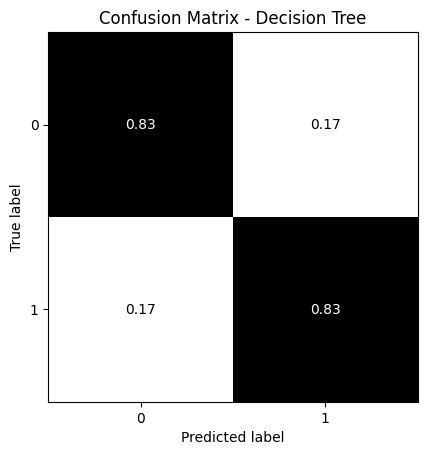

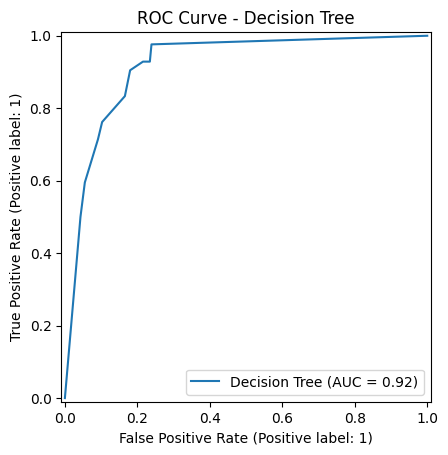

--- Báo cáo phân loại cho mô hình Random Forest trên tập Test ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6705
           1       0.11      0.19      0.14        42

    accuracy                           0.99      6747
   macro avg       0.55      0.59      0.57      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix for Random Forest:


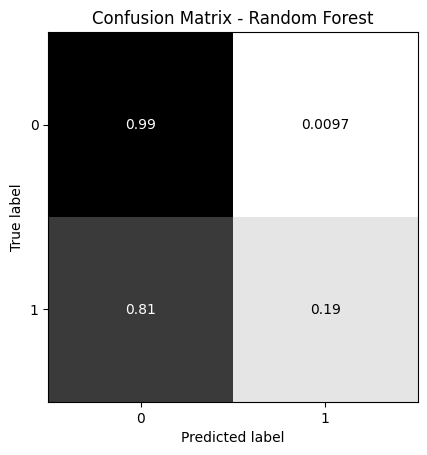

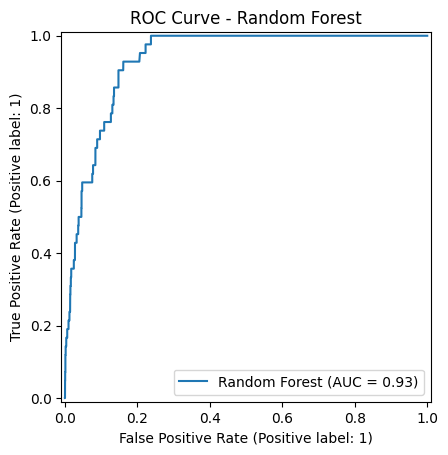

--- Báo cáo phân loại cho mô hình SVM trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      6705
           1       0.03      0.79      0.07        42

    accuracy                           0.86      6747
   macro avg       0.52      0.82      0.50      6747
weighted avg       0.99      0.86      0.92      6747


Confusion Matrix for SVM:


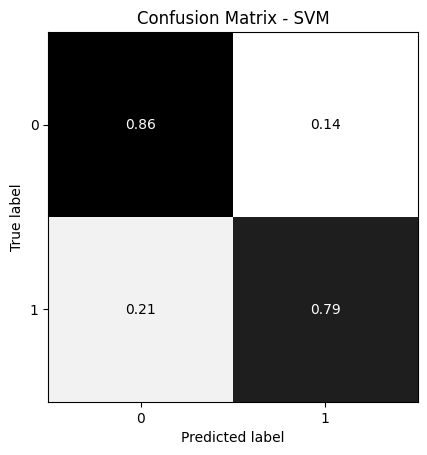

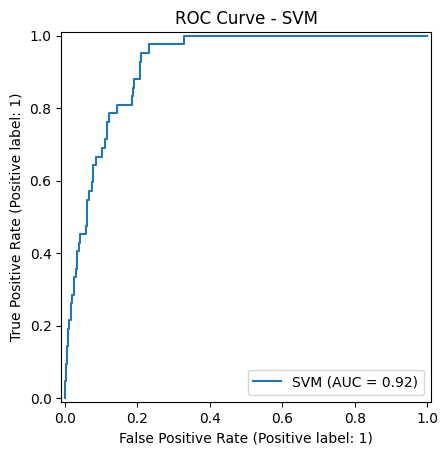

--- Báo cáo phân loại cho mô hình Naive Bayes trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      6705
           1       0.02      0.98      0.04        42

    accuracy                           0.73      6747
   macro avg       0.51      0.85      0.44      6747
weighted avg       0.99      0.73      0.84      6747


Confusion Matrix for Naive Bayes:


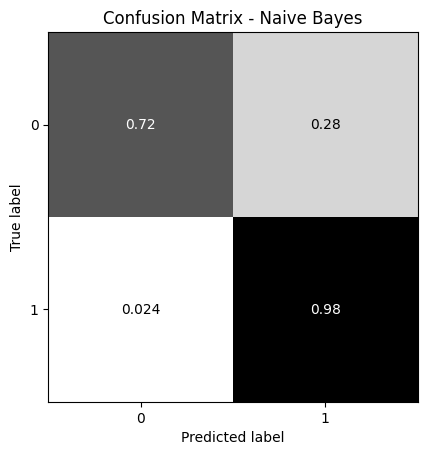

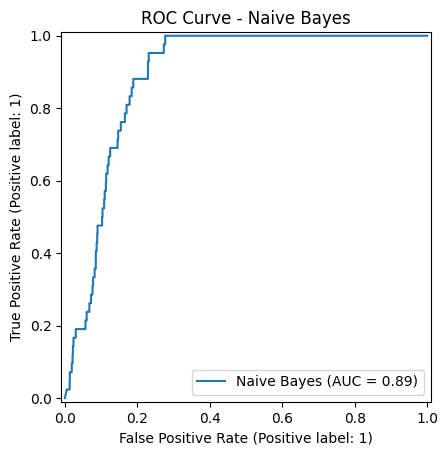

--- Báo cáo phân loại cho mô hình KNN trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6705
           1       0.07      0.38      0.12        42

    accuracy                           0.97      6747
   macro avg       0.53      0.68      0.55      6747
weighted avg       0.99      0.97      0.98      6747


Confusion Matrix for KNN:


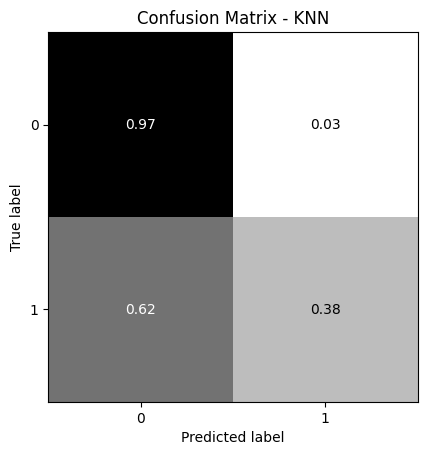

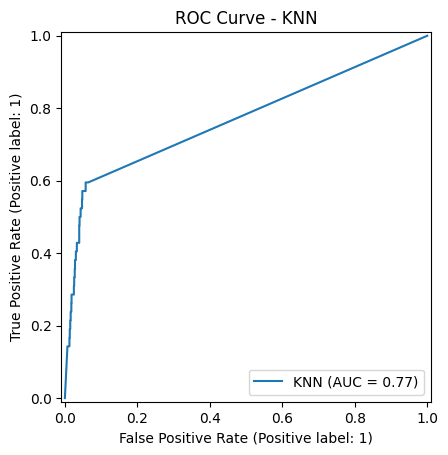

--- Báo cáo phân loại cho mô hình MLP trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6705
           1       0.08      0.31      0.13        42

    accuracy                           0.97      6747
   macro avg       0.54      0.64      0.56      6747
weighted avg       0.99      0.97      0.98      6747


Confusion Matrix for MLP:


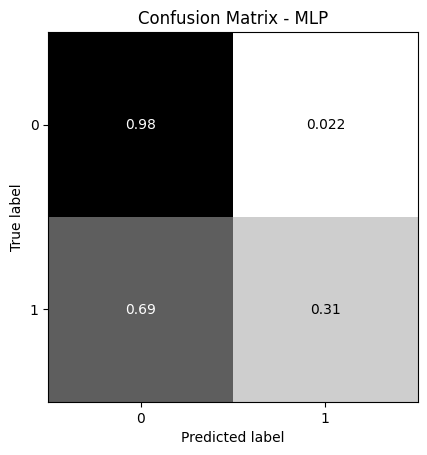

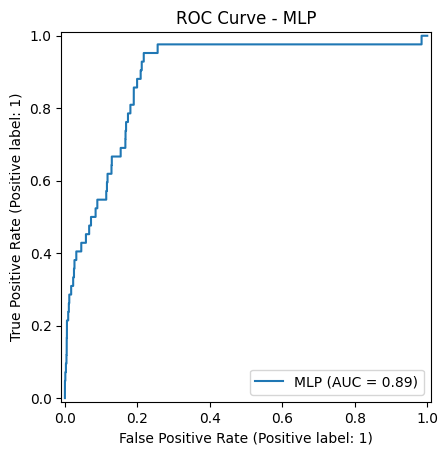

--- Báo cáo phân loại cho mô hình Bagging trên tập Test ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.57      0.10      0.16        42

    accuracy                           0.99      6747
   macro avg       0.78      0.55      0.58      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix for Bagging:


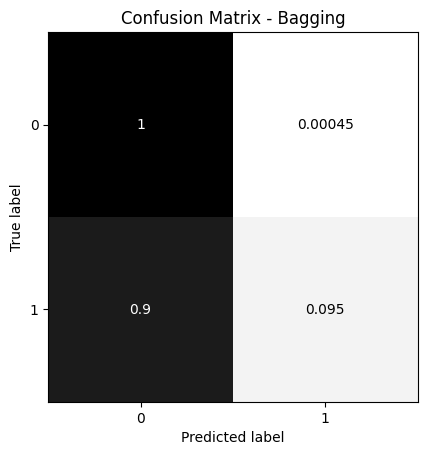

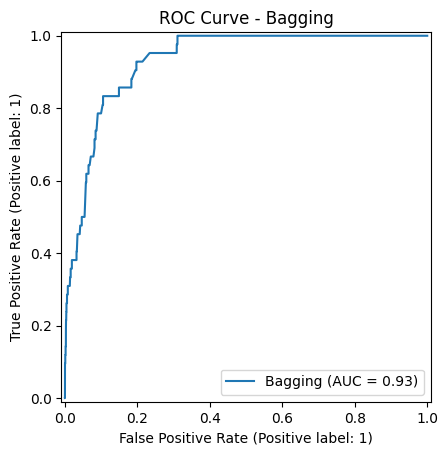

In [9]:
import os
import pickle
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay


# Tạo pipeline cho từng mô hình, tích hợp:
#   1) StandardScaler
#   2) SMOTE (chỉ trên train)
#   3) estimator
best_models_pipeline = {}
for model_name, model in best_models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),      # Bước chuẩn hóa feature
        ('smote', SMOTE(random_state=42)), # Bước oversample trên train
        ('model', model)                   # Mô hình đã tune
    ])
    best_models_pipeline[model_name] = pipe

# Huấn luyện và đánh giá
for model_name, pipeline in best_models_pipeline.items():
    # Fit pipeline trên tập X_train_val, y_train_val
    pipeline.fit(X_train_val, y_train_val)

    # Predict trên X_test (test không bị SMOTE/scale rò rỉ)
    y_test_pred = pipeline.predict(X_test)

    # Báo cáo phân loại
    print(f"--- Báo cáo phân loại cho mô hình {model_name} trên tập Test ---")
    print(classification_report(y_test, y_test_pred, zero_division=0))

    # Ma trận nhầm lẫn (normalize theo hàng)
    print(f"\nConfusion Matrix for {model_name}:")
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_test_pred,
        display_labels=pipeline.named_steps["model"].classes_,
        normalize='true',
        cmap='Greys',
        colorbar=False
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_estimator(
        pipeline,
        X_test,
        y_test,
        name=model_name
    )
    plt.title(f"ROC Curve - {model_name}")
    plt.show()
